In a previous notebook, I have shown how to [fit a psychometric curve using pyTorch](https://laurentperrinet.github.io/sciblog/posts/2020-04-08-fitting-a-psychometric-curve-using-pytorch.html). Here, I would like to review some nice properies of the logistic regression model (WORK IN PROGRESS). 

<!-- TEASER_END -->

Let's first initialize the notebook:

## initialisation 

In [1]:
import time
import os
import datetime
import numpy as np
import matplotlib.pyplot as plt

__Définition des variables et fonctions__ pour réaliser une classification  de données synthétiques selon une régression logistique

In [17]:
N = 256 # nombre de valeurs de l'entrée
n_classes = 10 # nombre de classes
N_batch = 100 # nombre d'entrée
seed = 1973

np.random.seed(seed)
W = np.random.randn(N+1, n_classes) # FIXED design matrix of weights (w) according to classes

# Definition de l'évidence (e) 
#def evidence(W, X):
    #e = ( X @ W[:-1, :]) + W[-1, :] # W[:-1, :] = N-1 poids pour n_classes /// W[-1, :] = 1 biais pour chaque classe
    #return e

# Transformation de l'entrée (e) en probabilité (p) selon une courbe de regression logistique
def psychometric_function(W, X):
    e = ( X @ W[:-1, :]) + W[-1, :]
    #e = evidence(W, X)
    return 1 / (1 + np.exp(-e))

# Tirage de Bernoulli : si p > à random => 1, si p < à random = 0 
def get_data(W, seed, N_batch):
    N, n_classes = W.shape[0]-1, W.shape[1]
    np.random.seed(seed)
    X = np.random.randn(N_batch, N) #nos entrées (X) n_batc entrées comprenant chacune N valeurs
    p = psychometric_function(W, X)
    y = p > 0.5# Bernoulli, generate data 
    
    return X, p, y

In [19]:
X, p, y = get_data(W, seed, N_batch)
e = (X @ W[:-1, :]) + W[-1, :]

In [22]:
X, p, y = get_data(W, seed, N_batch) 
#e = ( X @ W[:-1, :]) + W[-1, :]
X.shape, e.shape, p.shape, y.shape

((100, 256), (100, 10), (100, 10), (100, 10))

Avec __X,p,y = get_data(W, seed, N_batch)__ on appelle la fct get_data, qui appelle la fonction psychometric_function, qui appelle la fonction evidence afin de nous renvoyer les entrées X (100 entrées, comprenant chacune 256 valeures), les probabilités de classification de ces différentes entrées dans les différentes classes (p), et la classification après tirage de bernoulli (y = succès si p > 0.5, echcec si p < 0.5). Pour visualiser les sorties (p et y) en fonction des entrées (X et e), on les stock dans des arrays. 

__Visualisation des données__

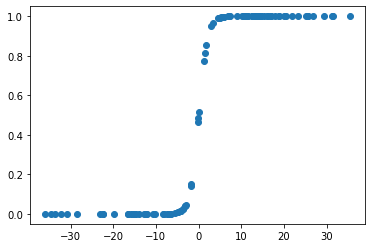

In [24]:
# Visualisation de p en fonction de e pour une classe 

plt.scatter(e[:,1],p[:,1]) 

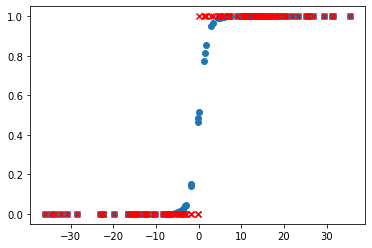

In [27]:
# Visualisation de p en fonction de e pour une classe + de la sortie (tirage de Bernoulli = y) 

plt.scatter(e[:,1],p[:,1]) #proba de e d'être classifié dans classe 1
plt.scatter(e[:,1],y[:,1],marker="x", color="red") #Sortie de Bernoulli 

(array([432.,  14.,  13.,  11.,   8.,   9.,   8.,  15.,  20., 470.]),
 array([2.91404343e-24, 1.00000000e-01, 2.00000000e-01, 3.00000000e-01,
        4.00000000e-01, 5.00000000e-01, 6.00000000e-01, 7.00000000e-01,
        8.00000000e-01, 9.00000000e-01, 1.00000000e+00]),
 <BarContainer object of 10 artists>)

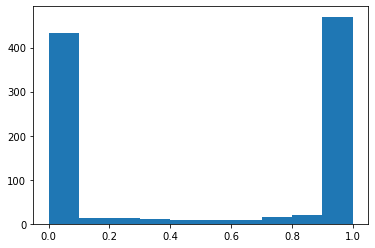

In [28]:
# Visualisation de la distribution des probabilités de classification 

plt.hist(p.ravel(), bins=10)

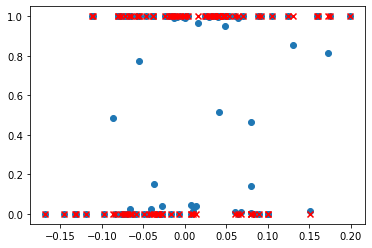

In [29]:
# Visualisation de p en fonction de chaque entrée X + de la sortie y 
# 'permise' par l'ajout des w et biais 

X_1 = np.average(X.reshape(-1, 256), axis=1)
plt.scatter(X_1,p[:,1]) 
plt.scatter(X_1,y[:,1],marker="x", color="red")

# Inversion

__Définition du réseau d'inversion__

In [30]:
import torch
from torch.utils.data import TensorDataset, DataLoader

torch.set_default_tensor_type("torch.DoubleTensor") # -> torch.tensor([1.2, 3]).dtype = torch.float64
# see https://sebastianraschka.com/faq/docs/pytorch-crossentropy.html#pytorch-loss-input-confusion-cheatsheet
criterion = torch.nn.BCELoss(reduction="mean") # loss divided by output size//the sum of the output will be divided by the number of elements in the output
#criterion = torch.nn.NLLLoss(reduction="mean") # loss divided by output 

class LogisticRegressionModel(torch.nn.Module):
    
    # voir ce que signifie self 
    # voir ce que signifie super 
    
    def __init__(self, N, n_classes, bias=True): # (self, input_dim, output_dim)
        super(LogisticRegressionModel, self).__init__() 
        
        # 1ere couche : self.linear = torch.nn.Linear(input_dim, output_dim, bias=true) bias = true pour apprentissage
        self.linear = torch.nn.Linear(N, n_classes, bias=bias) 
        
        # 2e couche : self.nl = torch.nn.Sigmoid() = ouputs 
        # autre possibilité : self.nl = torch.nn.LogSoftmax(n_classes)
        self.nl = torch.nn.Sigmoid()
    
    # maintenant qu'on a difinit les couches, on 
    # self.nl me donne la sigmoïde de e 
    # X = (N, n_batch) là on est dans 1 batch donc X = 256 = N 
    
    def forward(self, X):
        return self.nl(self.linear(X))

 __init__ permet de définir notre NN, les couches, leur role, la dimention des entrées et sorties
 
On a un réseau composé de deux couches : 
- la première (self.linear) réalise une transformation linéaire de nos entrées X (de dimention N =  256) de sorte à ce que la sortie y = (w*x)+biais = e (de dimention n_classes = 10). Une entrée sera associée aux différentes classes avec un w et un biais associé pour chacune des classes. Après plusieurs batch, on obtiendra plusieurs e pour la même ent alors plusieurs e pour chaque classes.
    
- la deuxième (self.nl) transforme ces sorties (e) pour leur donner une distribution sigmoïde. On obtient ainsi la probabilité de classification de l'entrée X, associée à un poid w et au biais. On aura n_classes sigmoïdes, représentant la probabilité de classification de l'entrée dans chacune des classes en fonction du w et du biais associé. 

La fonction __forward__ permet de construire le réseau en connectant les couches selon un modèle forward : self.nl(self.linear(X))

Par la suite, le réseau va modifier ses paramètres : w et biais de sorte à ce que la classification des X se fasse de la même manière que pendant l'initialisation

-> Pour cela, on demande à notre réseau de calculer la loss function entre la classification réalisée par self.nl(self.linear(X)) et celle réalisée par y 

-> Plus la différence est grande, plus la loss function l'est aussi et plus le réseau va modifier ses paramètres (W et biais) pour classifier de la même façon que pdt l'initialisation 

-> On devrait donc retrouver à la fin des W et des biais similaires entre ceux fixés par nous pendant l'initialisation et ceux déterminés par le réseau pdt l'inversion 


In [31]:
logistic_model = LogisticRegressionModel(N,n_classes) #(input_dim, output_dim)

In [32]:
bias_before_training = logistic_model.linear.bias
w_before_training = logistic_model.linear.weight
#bias_before_training.shape # shape = 10 car 1 biais associé à une classe, pour tous les x 
#w_before_training.shape # shape =  ([10, 256]) car pour chaque classe, on attribue 1 poid à chaque X

__Définition des variables d'apprentissage, d'entrée et de sortie__

In [33]:
learning_rate = 0.005
beta1, beta2 = 0.9, 0.999
betas = (beta1, beta2)
num_epochs = 2 ** 9 + 1 # epoch = le nombre de passages dans l'ensemble des données d'entraînement que le réseau a effectués, ici 513 max
amsgrad = False # gives similar results
amsgrad = True  # gives similar results

batch_size = 100
n_classes= 10

X = torch.randn(N_batch, N)
outputs = logistic_model(X)


__Défition des fonctions pour l'apprentissage des w et biais pour classification__

In [34]:
def fit_data(X, y, learning_rate=learning_rate,batch_size=batch_size,num_epochs=num_epochs,betas=betas,verbose=False, **kwargs):

    X_0 = torch.Tensor(X[:, None]) # rajoute une dimention de taille 1 : pk ? 
    labels = torch.Tensor(y[:, None]) # remplace les True/False par des 1 et 0, rajoute une dimention de taille 1 : pk ? 
    
    loader = DataLoader(TensorDataset(X_0, labels), batch_size=batch_size, shuffle=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    N_batch = X.shape[0] # = 100
    N = X.shape[1] # = 256 
    n_classes = y.shape[1] # = 10
    
    logistic_model = LogisticRegressionModel(N, n_classes)
    logistic_model = logistic_model.to(device)
    logistic_model.train()
    
    optimizer = torch.optim.Adam(logistic_model.parameters(), lr=learning_rate, betas=betas, amsgrad=amsgrad) # diminue le learning rate petit à petit de sorte à atteindre le minimum de la loss function / Adam utilise une moyenne à décroissance exponentielle des gradients passés afin de fournir une fréquence d'apprentissage adaptative. 
    
    for epoch in range(int(num_epochs)): # on commence à 1 jusq'à 513 epoch, cad qu'il passe par tous les X_ 513 fois
        logistic_model.train()
        losses = [] 
        for X_, labels_ in loader: 
            X_, labels_ = X_.to(device), labels_.to(device)
            outputs = logistic_model(X_)  
            loss = criterion(outputs, labels_) #calcul de la différence entre l'outpul de logistic_model et la classification effectuée pdt l'initialisation (PROBLEME ? on compare des proba à y=true/false)
                                               
            optimizer.zero_grad()
            loss.backward()
            optimizer.step() 
        
            
            losses.append(loss.item())   

        if verbose and (epoch % (num_epochs // 32) == 0):
            print(f"Iteration: {epoch} - Loss: {np.mean(losses):.5f}") 

    logistic_model.eval()
    X_0, labels = torch.Tensor(X[:, None]), torch.Tensor(y[:, None]) #utile ? 
    outputs = logistic_model(X_0) #utile ? 
    loss = criterion(outputs, labels).item()
    return logistic_model, loss

Dans la fonction __fit_data__ :
- On commence par __définir les variables d'intéret et l'optimizer__. Lors de la définition de l'optimizer, on lui indique __quel paramètre il doit modfier__ pendant l'apprentissage et le learning rate. Ici les paramètres modifiés par l'optimizer sont les poids et biais associés aux entrées pour les différentes classes. L'optimizer Adam va modifier le poid et le biais des différentes classes pour que la classfication des entrées soit similaire à celle obtenue pendant l'initialisation. Pour cela, il fait ........... . La particularité de cet optimizer est qu'il diminue le learning rate en même temps que la différence diminue. Le learning rate correspond au nombre de pas necessaire pour atteindre le minimum de loss function- à approfondir - 

- En suite, __on commence l'entrainement__ à partir des données comprises dans loader (= X_0, labels // équivalent à : N_batch entrées de N valeurs (= X) et N_batch sorties de n_classes valeurs (= y)). Dans un premier temps, on prend les X, on les fait passer dans le logistic_model et on récupère dans outputs les probabilités de classification des N_batch entrées. Ensuite, on compare la classification effectuée par le logistic_model avec celle effectuée dans l'iniitialisation. Le criterion calcule la différence entre les deux par le calcule de la BCE et on stock cette différence dans loss. L'optimizer va modifier les w et biais associés aux entrées pour les différentes classes de sorte à diminuer au plus possible la loss function au cours de différentes iterations. 

- On demande d'imprimer les loss_function toutes les itérations multiples de 32 

- ensuite on passe au __test du logistic_model__ et on renvoit la probabilté de classification des n_batch entrées ainsi que la loss_function après apprentissage des poids et biais optimaux pour que la classification se fasse comme dans l'initialisation. 

__On devrait ainsi obtenir des poids et biais similaires à ceux définis dans l'inialisation : C'est l'inversion__ 

On appelle la fonction get_data pour qu'elle nous renvoit les X, p et y.
On appelle la fonction fit_data pour réaliser l'apprentissage des w et biais et la classification et qu'elle nous renvoit le modele logistic entrainé et les pertes au cours de l'apprentissage et après l'apprentissage. 

In [41]:
X, p, y = get_data(W, seed=seed, N_batch=10000)
logistic_model, loss = fit_data(X, y, verbose=True)
print("Final loss =", loss)

Iteration: 0 - Loss: 0.42223
Iteration: 16 - Loss: 0.07466
Iteration: 32 - Loss: 0.05480
Iteration: 48 - Loss: 0.04598
Iteration: 64 - Loss: 0.04065
Iteration: 80 - Loss: 0.03694
Iteration: 96 - Loss: 0.03416
Iteration: 112 - Loss: 0.03202
Iteration: 128 - Loss: 0.03030
Iteration: 144 - Loss: 0.02879
Iteration: 160 - Loss: 0.02754
Iteration: 176 - Loss: 0.02644
Iteration: 192 - Loss: 0.02546
Iteration: 208 - Loss: 0.02460
Iteration: 224 - Loss: 0.02379
Iteration: 240 - Loss: 0.02315
Iteration: 256 - Loss: 0.02246
Iteration: 272 - Loss: 0.02190
Iteration: 288 - Loss: 0.02136
Iteration: 304 - Loss: 0.02080
Iteration: 320 - Loss: 0.02036
Iteration: 336 - Loss: 0.01994
Iteration: 352 - Loss: 0.01953
Iteration: 368 - Loss: 0.01914
Iteration: 384 - Loss: 0.01875
Iteration: 400 - Loss: 0.01844
Iteration: 416 - Loss: 0.01810
Iteration: 432 - Loss: 0.01780
Iteration: 448 - Loss: 0.01750
Iteration: 464 - Loss: 0.01722
Iteration: 480 - Loss: 0.01695
Iteration: 496 - Loss: 0.01669
Iteration: 512 -

In [42]:
bias_after_training = logistic_model.linear.bias
w_after_training = logistic_model.linear.weight

In [44]:
print('BIAIS')
print('before training,', bias_before_training)
print('after training,', bias_after_training) 
print('initialisation', W[-1, :])

BIAIS
before training, Parameter containing:
tensor([-0.0129,  0.0572, -0.0121, -0.0198, -0.0115,  0.0332,  0.0161, -0.0572,
         0.0369,  0.0071], requires_grad=True)
after training, Parameter containing:
tensor([ 2.4487,  0.2867, -0.3617,  4.5195, -0.4294,  4.7644,  3.9800, -0.7733,
         2.4800, -4.0629], requires_grad=True)
initialisation [ 1.22476992  0.1665627  -0.17190827  2.38852104 -0.2641366   2.56468991
  2.00251814 -0.45923941  1.40249567 -2.0906894 ]


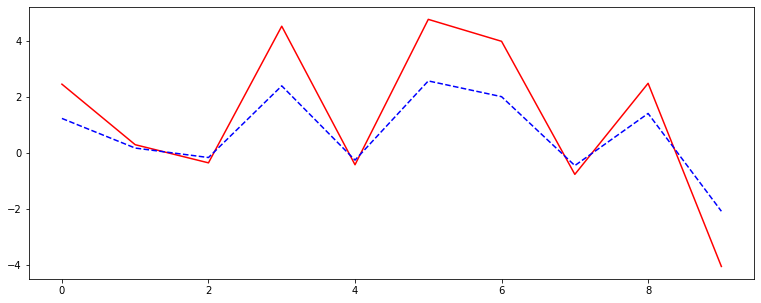

In [45]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(13, 5))
ax.plot(logistic_model.linear.bias.detach().numpy(), 'r')
ax.plot(W[-1, :], 'b--')

In [46]:
print('WEIGHT')
print('before training,', w_before_training)
print('after training,', w_after_training) 
print('initialisation : ', W[:-1,:].T)

WEIGHT
before training, Parameter containing:
tensor([[-0.0367,  0.0131,  0.0323,  ...,  0.0371,  0.0038,  0.0020],
        [-0.0482, -0.0435,  0.0566,  ..., -0.0588,  0.0050,  0.0491],
        [-0.0366, -0.0171, -0.0192,  ...,  0.0262,  0.0123, -0.0291],
        ...,
        [-0.0185, -0.0154, -0.0171,  ...,  0.0575,  0.0146,  0.0234],
        [ 0.0356,  0.0433,  0.0225,  ..., -0.0389,  0.0530, -0.0107],
        [ 0.0039, -0.0605, -0.0163,  ..., -0.0196, -0.0058,  0.0420]],
       requires_grad=True)
after training, Parameter containing:
tensor([[-3.7014, -1.7289,  1.5740,  ...,  0.6086,  1.0575, -0.3680],
        [-0.2307, -1.1947, -0.5116,  ...,  0.7899,  0.7283, -1.9536],
        [-1.7060, -0.3542,  0.3877,  ...,  1.8134, -1.2303, -0.0580],
        ...,
        [ 0.5880, -2.9901, -1.1109,  ...,  0.5903,  2.8518, -0.1103],
        [-0.6623,  1.5765, -2.5495,  ..., -2.0971, -0.0152, -0.7076],
        [ 1.4653,  0.9614, -0.6753,  ..., -0.2042,  2.8396,  3.4758]],
       requires_grad=

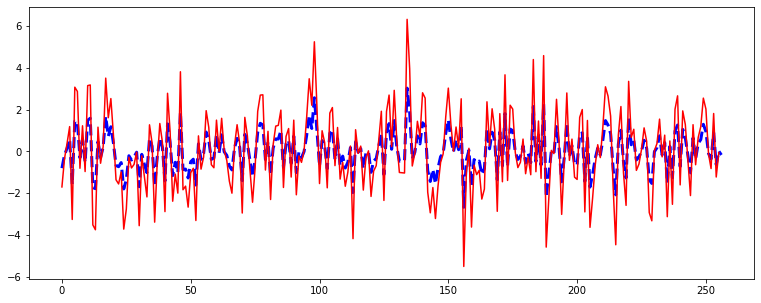

In [47]:
i_digit = 2
fig, ax = plt.subplots(figsize=(13, 5))
ax.plot(W[:, i_digit], 'b--', lw=3)
ax.plot(logistic_model.linear.weight[i_digit, :].detach().numpy(), 'r')

On voit que les biais et les poids ont changé après l'apprentissage pour se rapprocher de ceux de l'intialisation